In [1]:
!git clone "https://github.com/yuofi/ml_yandex-project"

Cloning into 'ml_yandex-project'...
remote: Enumerating objects: 88007, done.
remote: Counting objects: 100% (27068/27068), done.
remote: Compressing objects: 100% (27046/27046), done.
remote: Total 88007 (delta 22), reused 27063 (delta 18), pack-reused 60939
Receiving objects: 100% (88007/88007), 1.24 GiB | 37.58 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (87938/87938), done.


In [ ]:
'''import os
from PIL import Image


target_dir = "data\\lung_overlay"


if not os.path.exists(target_dir):
    os.makedirs(target_dir)

lung_path = "data\\train_images"
mask_path = "data\\train_lung_masks"
result_path = "data\\lung_overlay"

for filename in os.listdir(lung_path):
    mask = Image.open(f'{mask_path}\\{filename}')
    lung = Image.open(f'{lung_path}\\{filename}')
    if mask.size == lung.size:
        mask_pixels = mask.load()
        lung_pixels = lung.load()
        width, height = mask.size
        for x in range(width):
            for y in range(height):
                if mask_pixels[x, y] == 0:
                    lung_pixels[x, y] = 0

        save_path = os.path.join(result_path, filename)
        lung.save(save_path)

display(Image.open(f'{result_path}\\img_1.png'))'''

'import os\nfrom PIL import Image\n\n\ntarget_dir = "data\\lung_overlay"\n\n\nif not os.path.exists(target_dir):\n    os.makedirs(target_dir)\n\nlung_path = "data\\train_images"\nmask_path = "data\\train_lung_masks"\nresult_path = "data\\lung_overlay"\n\nfor filename in os.listdir(lung_path):\n    mask = Image.open(f\'{mask_path}\\{filename}\')\n    lung = Image.open(f\'{lung_path}\\{filename}\')\n    if mask.size == lung.size:\n        mask_pixels = mask.load()\n        lung_pixels = lung.load()\n        width, height = mask.size\n        for x in range(width):\n            for y in range(height):\n                if mask_pixels[x, y] == 0:\n                    lung_pixels[x, y] = 0\n\n        save_path = os.path.join(result_path, filename)\n        lung.save(save_path)\n\ndisplay(Image.open(f\'{result_path}\\img_1.png\'))'

In [44]:
from sklearn.model_selection import train_test_split
from torchvision.datasets import FashionMNIST
from torch.utils.data import TensorDataset
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T
from torchvision import transforms, datasets
from torch.optim import Optimizer
from torchsummary import summary
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from torch import nn
import pandas as pd
import numpy as np
import random
import numpy
import torch

In [45]:
import os
import pandas as pd
from PIL import Image as PILImage
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, "img_" + str(self.img_labels.iloc[idx, 0]))  + '.png'
        image = PILImage.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [46]:
img_dir = 'data/lung_overlay'
annotations_file = 'data/train_answers.csv'

transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize((256, 256))
    ]
)

dataset = CustomImageDataset(img_dir=img_dir, annotations_file=annotations_file, transform=transform)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [47]:
print(dataset[0][0].shape)

torch.Size([1, 256, 256])


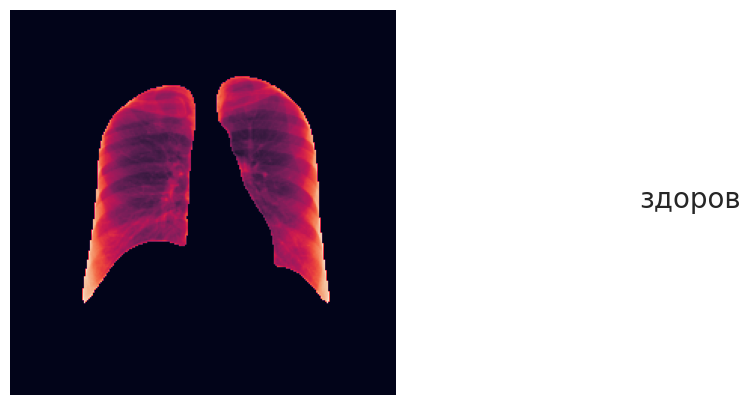

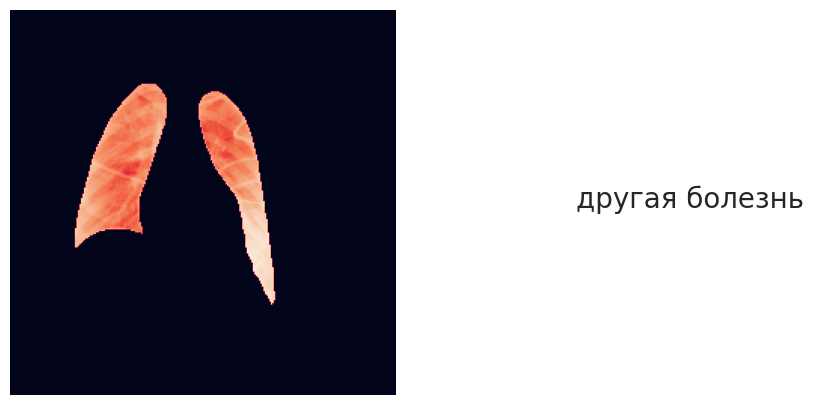

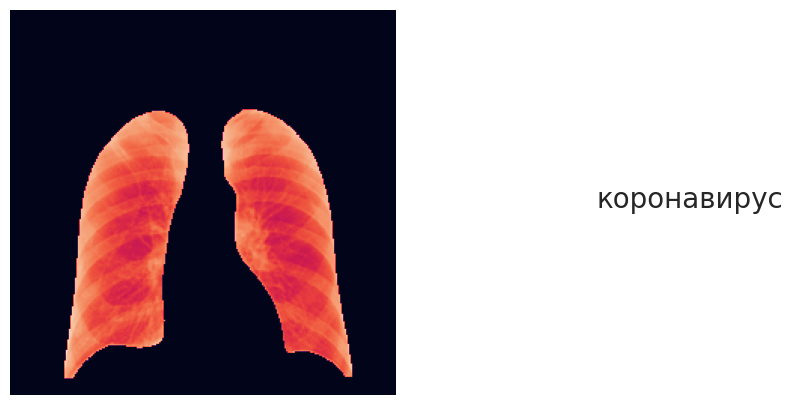

In [48]:
arr = dict({"0" : "здоров", "1": "коронавирус", "2" : "другая болезнь"})

for i in ([0, 1, 1000]):
    img, label_idx = dataset[i]
    img = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(img)
    ax.axis('off')

    label_text = arr[str(label_idx)]
    fig.text(1, 0.5, label_text, fontsize=20, ha='center', va='center')

    plt.show()

In [49]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [50]:
loader = DataLoader(dataset, batch_size=32, num_workers=0, shuffle=True)

means, stds = calculate_mean_std(loader)


In [51]:
norm_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

dataset_norm = CustomImageDataset(img_dir=img_dir, annotations_file=annotations_file, transform=norm_transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [53]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [54]:
from torch import nn


class Model1(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # 256 x 256 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 128 x 128 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 128 x 128 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 64 x 64 x 32

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 64 x 64 x 64
            nn.ReLU(),

            nn.MaxPool2d(2),  # 32 x 32 x 64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 32 x 32 x 128
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 128

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # 16 x 16 x 256
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 256

            nn.Flatten(),

            nn.Linear(in_features=8*8*256, out_features=1024),
            nn.ReLU(),

            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=16),
            nn.ReLU(),

            nn.Linear(in_features=16, out_features=3)

        )


    def forward(self, x):
        return self.net(x)


In [55]:
@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [56]:
import matplotlib.pyplot as plt


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [57]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [68]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model1().to(device)

summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
             ReLU-14          [-1, 256,

In [69]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


indices = list(range(len(dataset_norm)))


train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_dataset = Subset(dataset_norm, train_indices)
test_dataset = Subset(dataset_norm, test_indices)

print(len(train_dataset), len(test_dataset))

21600 5400


In [70]:
BATCH_SIZE=128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

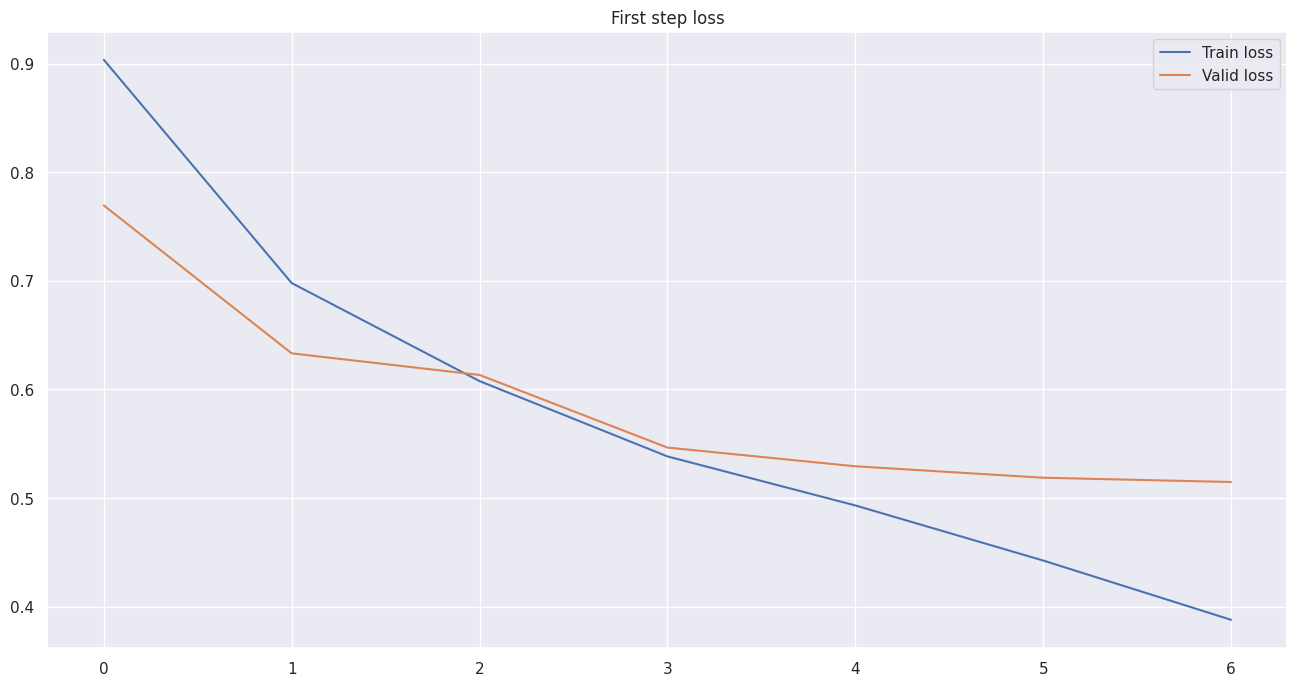

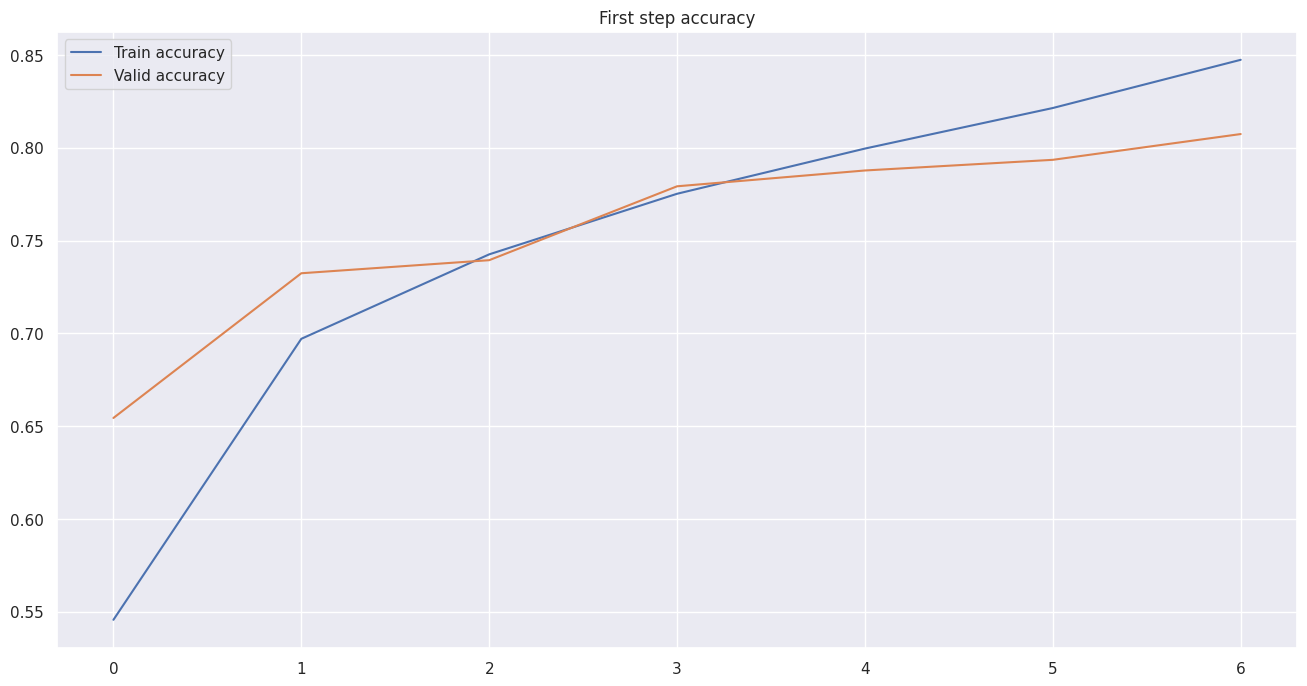

In [71]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

fit(model, train_loader, valid_loader, optimizer, loss_fn, device, 7, 'First step')

In [72]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_metrics(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_y = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            preds = preds.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_y.extend(y.cpu().numpy())

    accuracy = accuracy_score(all_y, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_y, all_preds, average='macro')

    return accuracy, precision, recall, f1

In [73]:
import pandas as pd

accuracy, precision, recall, f1 = calculate_metrics(model, valid_loader)
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
}
df = pd.DataFrame(data)
print(df)

      Metric     Value
0   Accuracy  0.807407
1  Precision  0.807687
2     Recall  0.808484
3   F1-Score  0.807495


In [74]:
from torch import nn


class Model2(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # 256 x 256 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 128 x 128 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 128 x 128 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 64 x 64 x 32

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 64 x 64 x 64
            nn.ReLU(),

            nn.MaxPool2d(2),  # 32 x 32 x 64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 32 x 32 x 128
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 128

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # 16 x 16 x 256
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 256

            nn.Flatten(),

            nn.Linear(in_features=8*8*256, out_features=1024),
            nn.ReLU(),

            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=16),
            nn.ReLU(),

            nn.Linear(in_features=16, out_features=3)

        )


    def forward(self, x):
        return self.net(x)


In [75]:
img_dir = 'data/lung_overlay'
annotations_file = 'data/train_answers.csv'

transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize((256, 256))
    ]
)

auto_dataset = CustomImageDataset(img_dir=img_dir, annotations_file=annotations_file, transform=transform)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [76]:
loader = DataLoader(auto_dataset, batch_size=32, num_workers=0, shuffle=True)

means, stds = calculate_mean_std(loader)

In [77]:
norm_auto_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

dataset_norm_auto = CustomImageDataset(img_dir=img_dir, annotations_file=annotations_file, transform=norm_auto_transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [78]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model2 = Model2().to(device)

summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
             ReLU-14          [-1, 256,

In [79]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


indices = list(range(len(dataset_norm_auto)))


train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_dataset = Subset(dataset_norm_auto, train_indices)
test_dataset = Subset(dataset_norm_auto, test_indices)

print(len(train_dataset), len(test_dataset))

21600 5400


In [80]:
BATCH_SIZE=128

train_loader2 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
valid_loader2 = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


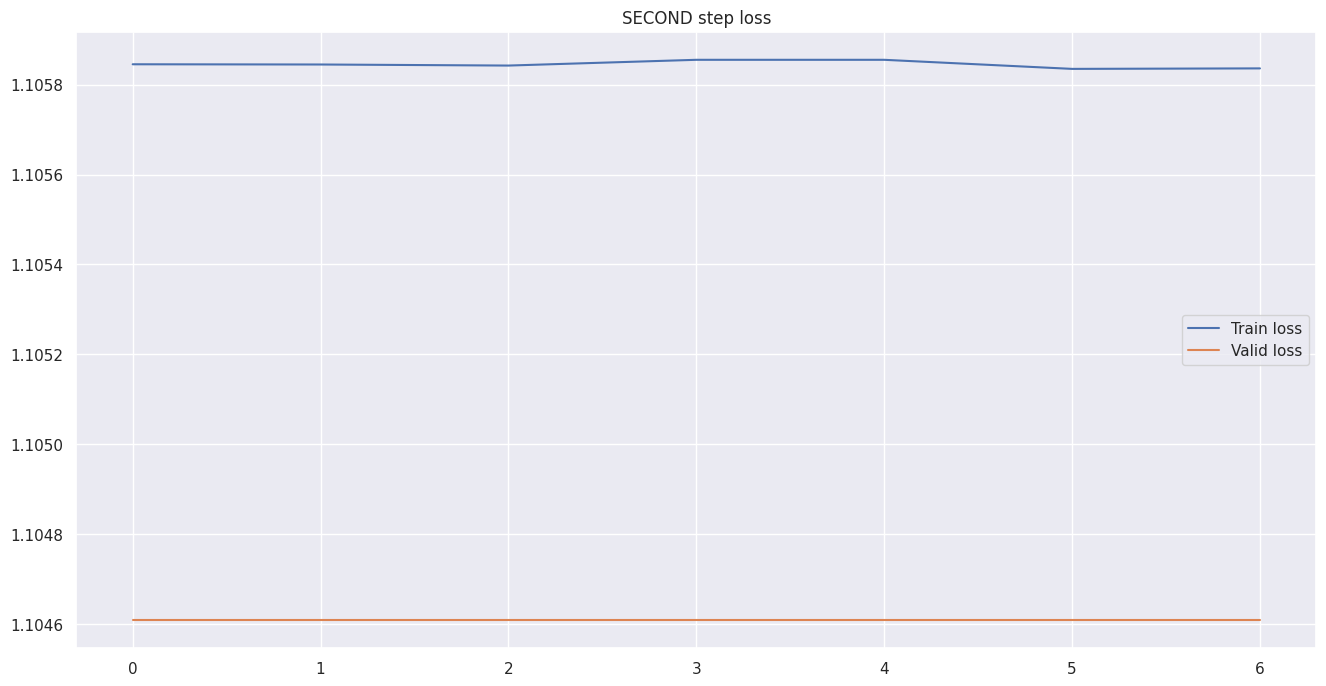

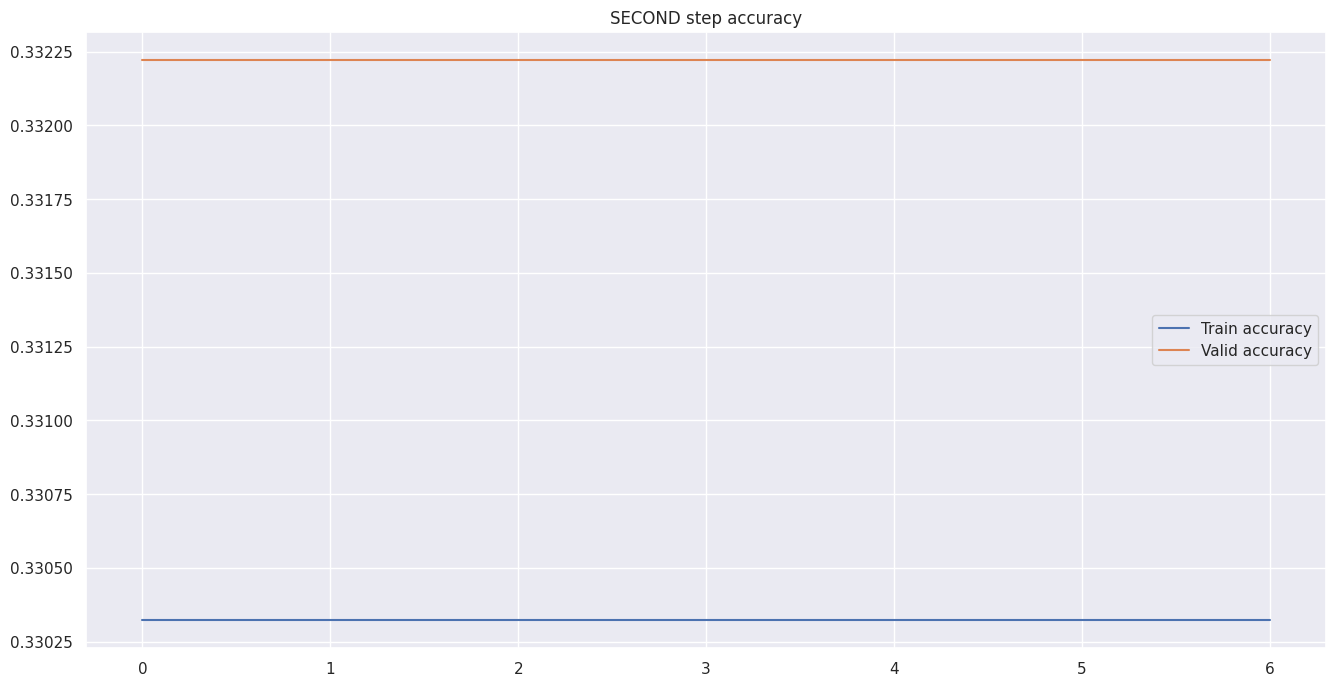

In [81]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

fit(model2, train_loader2, valid_loader2, optimizer, loss_fn, device, 7, 'SECOND step')

In [82]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_metrics(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_y = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            preds = preds.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_y.extend(y.cpu().numpy())

    accuracy = accuracy_score(all_y, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_y, all_preds, average='macro')

    return accuracy, precision, recall, f1

In [83]:
import pandas as pd

accuracy2, precision2, recall2, f12 = calculate_metrics(model2, valid_loader2)
data = {
    'Metric': ['Accuracy2', 'Precision2', 'Recall2', 'F1-Score2'],
    'Value': [accuracy2, precision2, recall2, f12]
}
df = pd.DataFrame(data)
print(df)

       Metric     Value
0   Accuracy2  0.332222
1  Precision2  0.110741
2     Recall2  0.333333
3   F1-Score2  0.166250


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
